# Семинар 9: рекуррентные нейронные сети

На прошлом занятии мы познакомились с тем, как можно векторизовать текстовые данные для решения задач обработки текстов. Сегодня мы продолжим заниматься текстами.

В этой тетрадке мы попробуем генерировать Эльфийские имена. Чтобы хотябы одна модель обучилась. В свободное время вы можете попробовать запустить этут терадку [на датасете из анекдотов.](https://t.me/NeuralShit/2321) Вы хорошо поработали в этом семестре и заслужили немного веселья.

# Генерация эльфийских имён

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter

plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Данные

In [3]:
import pickle

with open('elvish-names.pickle', "rb") as file:
    names_data = pickle.load(file)

In [5]:
import numpy as np
np.random.choice(names_data, 10)

array(['yeshelne', 'mhaenal', 'khidell', 'akkar', 'cheyrth', 'alabyran',
       'isciira', 'vesryn', 'sythaeryn', 'foxattwilight'], dtype='<U14')

In [6]:
len(names_data)

914

Займёмся токенизацией текста. Будем строить модель, предсказывающую следующий символ. Поэтому в качестве отдельных токенов будем на данном этапе рассматривать буквы.

Модель будет по текущей букве предсказывать следующую. Тогда мы сможем запускать её в режиме генерации новых текстов, подав на вход модели произвольный набор символов. Чтобы удобно работать с текстами, напишем `NamesDataset`.

Как он будет устроен:

- Токенизация будет идти по символам. Мы будем строить из них словарь `char2indx` и переводить в индексы. Словарь `indx2char` будет делать обратную операцию.
- Первые три индекса зарезервированы для `<pad>, <bos>, <eos>`. Это специальные токены для заполнения пустоты, начала последовательности и конца последовательности.
- Метод `encode(str)` превращает строку в список индексов.
- Метод decode(indices) делает обратное — из индексов в строку.
- `__getitem__` будет возвращать по индексу конкреный элемент, последовательность обрезаннуб до ` max_len` и её фактическую длину без паддингов.


In [9]:
from nltk import sent_tokenize

class NamesDataset(Dataset):
    """Датасет для символьных моделей (например, RNN).
    Преобразует список строк в тензоры с паддингом и спецтокенами <bos>/<eos>/<pad>.
    """
    def __init__(self, texts):
        self.texts = texts # датасет храним в оперативке
        self.specials = {'<pad>': 0, '<bos>': 1, '<eos>': 2}
        self.char2indx = dict()
        self.indx2char = dict()

        # двойка для '<bos>' и '<eos>'
        self.max_len = max([len(item) for item in self.texts]) + 2

        self.__build_vocab(texts)
        self.pad_index = self.char2indx['<pad>']
        self.bos_index = self.char2indx['<bos>']
        self.eos_index = self.char2indx['<eos>']

    def __build_vocab(self, texts):
        """Создаёт словарь символов на основе корпуса и добавляет спецтокены."""
        chars = set()
        for item in texts:
            chars.update(list(item.strip()))
        self.char2indx.update(self.specials)
        self.char2indx.update(dict(zip(chars, range(3, len(chars) + 3))))
        self.indx2char = {i:c for c,i in self.char2indx.items()}

    def __str_to_idx(self, chars):
        """Преобразует список символов в список индексов."""
        return [self.char2indx[char] for char in chars]

    def __idx_to_str(self, idx):
        """Преобразует список индексов обратно в символы."""
        return [self.indx2char[index] for index in idx]

    def encode(self, chars):
        """Добавляет <bos> и <eos>, затем переводит строку в индексы."""
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.__str_to_idx(chars)

    def decode(self, idx):
        """Переводит индексы обратно в строку, убирая спецтокены."""
        chars = self.__idx_to_str(idx)
        return ''.join(char for char in chars if char not in self.specials)

    def __len__(self):
        """Возвращает количество примеров в датасете."""
        return len(self.texts)

    def __getitem__(self, item):
        """Возвращает паддированную последовательность и её реальную длину."""
        encoded = self.encode(self.texts[item])
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.int64)
        padded[:len(encoded)] = torch.tensor(encoded)
        return padded, len(encoded)

Опробуем датасет!

In [10]:
dataset = NamesDataset(names_data)

In [13]:
dataset.char2indx['d']

10

In [15]:
dataset.indx2char[20]

'z'

In [16]:
dataset.texts[42]

'aloevan'

In [18]:
dataset.encode('aloevan')

[1, 28, 6, 21, 27, 8, 28, 16, 2]

In [25]:
dataset.decode([ 1,  5, 15, 26, 10, 10, 23, 16,  2,  0,  0,  0,  0,  0,  0,  0])

'myrddin'

In [20]:
print('pad_index:', dataset.pad_index)
print('bos_index:', dataset.bos_index)
print('eos_index:', dataset.eos_index)

pad_index: 0
bos_index: 1
eos_index: 2


Создадим `dataloader`

In [21]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [22]:
x, lengths = next(iter(dataloader))

In [23]:
# 0 - <pad>
# 1 - <bos>
# 2 - <eos>
x[:4]

tensor([[ 1,  5, 15, 26, 10, 10, 23, 16,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  7,  4, 28, 21, 26, 16, 23, 19,  2,  0,  0,  0,  0,  0,  0],
        [ 1, 26, 27, 16, 27, 18, 13, 26, 28, 27,  2,  0,  0,  0,  0,  0],
        [ 1, 18, 28, 26, 15, 28,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [24]:
lengths[:4]

tensor([ 9, 10, 11,  7])

## Модель

Пайплайн обработки данных у нас выглядит сейчас следующим образом:

chars (tokens) $\to$ indices $\to$ embeddings $\to$ RNN output, hidden $\to$ next char logits

Модель будем собирать из нескольких слоёв:

- `nn.Embedding` — обучаемое представление символов (word2vec c спрошлой пары)
- `nn.RNN` - рекурретнтый слой. Вместо него можно также взять `LSTM` или `GRU` слой. Он принимает на вход последовательность векторов и возвращает скрытое состояние и прогноз.
- `nn.Linear` — проекция из скрытого состояния RNN (размер hidden_dim) в пространство всех символов для предсказания их вероятностей.

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/recurrent-neural-networks/char-rnn/assets/charRNN.png?raw=1" width=50%>

In [26]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

In [48]:
class Generator(nn.Module):
    def __init__(self, embed_dim=32, hidden_dim=32, out_dim=len(dataset.char2indx)):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=len(dataset.char2indx),  # число векторов, L
            embedding_dim=embed_dim,                # размер векторов, E
            padding_idx=dataset.pad_index           # для padding мы не будем учить представление
        )
        self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, out_dim)

    def forward(self, tokens, lengths):
        '''
        B - batch size
        L - sequence length
        E - embedding dim
        H - hidden dim
        V - vocab size
        '''
        # tokens: (B, L)
        embeds = self.embedding(tokens)
        # embeds: (B, L, E) in padded form
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed_embeds)
        # output: (B, L, H), hidden: (B, H) in packed form
        outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        logits = self.linear(outputs)
        # logits: (B, L, V)
        return logits

    @torch.no_grad()
    def inference(self, dataset, max_len=20, prefix=''):
        '''Функция для генерации новых текстов'''

        # кодируем префикс в токены
        tokens = dataset.encode(prefix)[:-1]
        tokens = torch.tensor(tokens).unsqueeze(0).to(device)

        # строим прогноз для следующего символа по поступившим на вход
        embeds = self.embedding(tokens)
        output, hidden = self.rnn(embeds)
        logits = self.linear(output)

        # сэмплируем новый токен
        new_tokens = Categorical(logits=logits[:, -1:]).sample()
        tokens = torch.cat([tokens, new_tokens], dim=1)

        # условие остановки: достижение максимальной длины или генерация <eos>
        while tokens.shape[1] < max_len:
            if new_tokens.item() == dataset.eos_index:
                break

            embeds = self.embedding(new_tokens)
            output, hidden = self.rnn(embeds, hidden)
            logits = self.linear(output)

            new_tokens = Categorical(logits=logits[:, -1:]).sample()
            tokens = torch.cat([tokens, new_tokens], dim=1)

        # декодируем результат
        return dataset.decode(tokens.squeeze().cpu().tolist())

Важные нюансы:

- Параметр `batch_first=True` говорит, что в первой размерности размер батча. По дефолту RNN ожидает, что первый символ это длина последовательности (так исорически сложилось, не спрашивайте).

- Когда батч состоит из последовательностей разной длины, их обычно дополняют `<pad>` до длины самой длинной. Если просто подать батч в RNN как есть, модель будет обрабатывать паддинги, т.е. делать лишние шаги на 0. Чтобы избежать этого используют функции `pack_padded_sequence` и `pad_packed_sequence`.
- `pack_padded_sequence`помогает эффективно работать с `<pad>` на конце строк и игнорировать их.
- `pad_packed_sequence` разворачивает последовательность назад в исходную форму.

Посмотрим на примере.

In [49]:
tokens = torch.tensor([
    [1, 0, 0],   # длина 1
    [2, 3, 0],   # длина 2
    [1, 2, 3]    # длина 3
], dtype=torch.long)

lengths = torch.tensor([1, 2, 3])  # реальные длины без паддинга

# Параметры RNN
embed_dim = 2
hidden_dim = 3
vocab_size = 4

# Embedding
embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
emb = embedding(tokens)  # (batch, seq_len, embed_dim)
emb

tensor([[[-0.6634,  1.3830],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[-0.7492, -0.3106],
         [ 1.8581, -0.4090],
         [ 0.0000,  0.0000]],

        [[-0.6634,  1.3830],
         [-0.7492, -0.3106],
         [ 1.8581, -0.4090]]], grad_fn=<EmbeddingBackward0>)

In [50]:
# Упаковываем последовательности перед RNN
packed = pack_padded_sequence(emb, lengths, batch_first=True, enforce_sorted=False)
packed

PackedSequence(data=tensor([[-0.6634,  1.3830],
        [-0.7492, -0.3106],
        [-0.6634,  1.3830],
        [-0.7492, -0.3106],
        [ 1.8581, -0.4090],
        [ 1.8581, -0.4090]], grad_fn=<PackPaddedSequenceBackward0>), batch_sizes=tensor([3, 2, 1]), sorted_indices=tensor([2, 1, 0]), unsorted_indices=tensor([2, 1, 0]))

In [51]:
# RNN
rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
out_packed, h_n = rnn(packed)
out_packed

PackedSequence(data=tensor([[ 0.8613, -0.7125,  0.1547],
        [ 0.4562, -0.4073,  0.5079],
        [ 0.8613, -0.7125,  0.1547],
        [ 0.5822,  0.2933,  0.6200],
        [ 0.5610,  0.2204,  0.4871],
        [ 0.5346,  0.0120,  0.7323]], grad_fn=<CatBackward0>), batch_sizes=tensor([3, 2, 1]), sorted_indices=tensor([2, 1, 0]), unsorted_indices=tensor([2, 1, 0]))

In [52]:
h_n

tensor([[[ 0.8613, -0.7125,  0.1547],
         [ 0.5610,  0.2204,  0.4871],
         [ 0.5346,  0.0120,  0.7323]]], grad_fn=<IndexSelectBackward0>)

In [53]:
# Распаковываем обратно в padded тензор
out, out_lengths = pad_packed_sequence(out_packed, batch_first=True)
out

tensor([[[ 0.8613, -0.7125,  0.1547],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.4562, -0.4073,  0.5079],
         [ 0.5610,  0.2204,  0.4871],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.8613, -0.7125,  0.1547],
         [ 0.5822,  0.2933,  0.6200],
         [ 0.5346,  0.0120,  0.7323]]], grad_fn=<IndexSelectBackward0>)

Мы будем использовать получившуюся модель для генерации новых текстов. Для этого мы написали в модели функцию `inference`. Она будет предсказывать следующий токен и отдавать его нам, пока не получится новый текст. Давайте объявим модель и попробуем что-нибудь сгенерировать её необученной версией.

In [54]:
model = Generator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.pad_index)

In [55]:
# необученная модель генрирует мусор
[model.inference(dataset, max_len=20, prefix='') for _ in range(10)]

['vtspeymncagaxoaoh',
 'sidyulqg',
 'paftfdjsovhgdwax',
 'ajkredprjudetqi',
 'kzffhafcvkcuvejpkyu',
 'ztvdvuinefgonwma',
 'ewvaivodkthwdvsfwm',
 'bwx',
 'bufrvgfbscasozyaxh',
 'wnhywfiwijlrkkvida']

Пока что модель генерирует нам мусор, а не имена.

## Обучение модели

По классике, используем оптимизатор Adam и кросс-энтропию. Будем использовать gradient clipping, чтобы избавиться от взрывающихся градиентов.

In [56]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

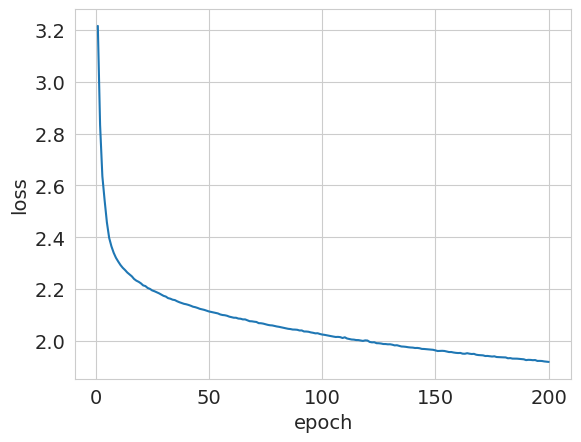

In [57]:
losses = []
num_epochs = 200
max_grad_norm = 1.0  # порог для обрезки градиента, чтобы избежать взрывов

for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    model.train()
    for tokens, lengths in dataloader:
        optimizer.zero_grad()
        tokens = tokens[:, :lengths.max()].to(device)
        logits = model(tokens[:, :-1], lengths - 1)

        # logits: (B, L, V), tokens: (B, L) - надо транспонировать
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()

        # порезали градиенты
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        running_loss += loss.item() * tokens.shape[0]

    losses += [running_loss / len(dataset)]

    if epoch % 10 == 0:
        plot_losses(losses)

In [58]:
# попробуем ещё разок
[model.inference(dataset, max_len=20, prefix='') for _ in range(10)]

['dandra',
 'saeriandel',
 'eorindrra',
 'tyremn',
 'kornar',
 'rhaajaa',
 'chissarshea',
 'nhaudie',
 'ndbranth',
 'ruven']

Скорее всего, Женя Соколов всегда хотел себе настоящие эльфийское альтер эго. Давайте сгенерируем для него несколько вариантов имён с помощью условной генерации.

In [59]:
# условная генерация
[model.inference(dataset, max_len=20, prefix='evg') for _ in range(10)]

['evgrynt',
 'evgustria',
 'evgahs',
 'evgion',
 'evgor',
 'evgor',
 'evgyth',
 'evgaeralll',
 'evgion',
 'evgish']

In [61]:
# новые эльфы не пересекаются с обучающей выборкой
new_names = set([model.inference(dataset, max_len=20, prefix='') for _ in range(10)])
set(dataset.texts) & new_names

set()

## Задание 1

Попробуйте использовать `LSTM` слой вместо `RNN`, сделайте в нейросетке два слоя вместо одного.

## Задание 2

Функция `Softmax` считает мягкий максимум. Он при трансформации полученных для каждой категории чисел в вероятности, пытается приподнять самое большое число и приопустить маленькие, мягко выделяя максимум.

Силу такого выделения можно контролировать. Для этого в формулу вшивается дополнительный параметр $T$, который называют **температурой сэмплирования**

$$
\frac{e^{\tfrac{z_i}{T}}}{ \sum_{k=1}^K e^{\tfrac{z_k}{T}}}.
$$

- Если $T \to \infty$, тогда $e^{\tfrac{z_i}{T}} \to 1$. Сэмплирование будет идти из равномерного распределения.
- Если $T \to 0,$ мы получим распределение полностью сосредоточенное в исходе с максимальным весом.

Маленькие значения $T$ сделают генерацию однотипной, а большие разнообразной. Понятное дело, что если распределение окажется близким к равномерному, генерация будет рандомной. Темературу сэмплирования надо подбирать аккуратно.

Реализуйте механимз с температурой в функции `inference` и сделайте несколько генераций.

In [ ]:
# зададим какой-то вход для модели
x = torch.tensor([[ 1,  5, 15, 26, 10, 10, 23, 16,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  7,  4, 28, 21, 26, 16, 23, 19,  2,  0,  0,  0,  0,  0,  0]])
l = torch.tensor([9,10])

# сейчас наша модель прогнозирует логиты и дальше сэмплирует пропорционально им
logits = model(x.to(device), l)
logits[:, -1:].shape

In [ ]:
# можно взять от логитов софтмакс и сделать сэмпл
probs = torch.softmax(logits[:, -1:], dim=-1)
Categorical(probs).sample()

In [ ]:
# добавим температуру сэмплирования и посмотрим что произойдёт
T = 0.01
probs = torch.softmax(logits[:, -1:]/T, dim=-1)
Categorical(probs).sample()

In [ ]:
T = 10
probs = torch.softmax(logits[:, -1:]/T, dim=-1)
Categorical(probs).sample()

## Задание 3

Выше мы с вами использовали посимвольную токенизацию. На самом деле это не лучший способ. В современных языковых моделях в качестве токенизатора довольно часто используют BPE (Byte-pair Encoder).

BPE помогает объединить лучшее из двух миров: токенизацию по символам (чтобы сократить словарь) и токенизацию по словам (чтобы лучше понимать семантическую структуру). Он начинается со словаря отдельных символов и итеративно объединяет наиболее часто встречающиеся пары символов (символов или последовательностей) в корпусе для формирования новых токенов. Мы продолжаем «склеивать» эти токены, пока не достигнем необходимого размера словаря.

Рассмотрим работу BPE на примере текста `"бобры добры"`.

1. BPE начинает с словаря отдельных символов. Каждый символ - это отдельный токен.

`['б', 'о', 'б', 'р', 'ы', ' ', 'д', 'о', 'б', 'р', 'ы']`

2. Итеративное объединение частых пар. BPE ищет самые частые пары символов в корпусе (или фразе) и объединяет их в новые токены.

Например, у нас в корпусе чаще всего встречается `"б" + "р"` и мы должны их соеденить.

`['б' 'о', 'бр', 'ы', ' ', 'д', 'о', 'бр', 'ы']`

3. Продолжаем эту процедуру до тех пор, пока словарь не разрастётся до заранее заказанного размера. Все частып подслова будут отдельными токенами, а редкие комбинации останутся разделены.



In [ ]:
import numpy as np
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

texts = np.array([
    'бобры добры', 'добры бобры', 'бобры добры', 'бобры бодры'
])

# Создаём токенайзер с моделью BPE
tokenizer = Tokenizer(models.BPE())

# Указываем, как разбивать текст перед обучением
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Обучаем токенайзер
trainer = trainers.BpeTrainer(vocab_size=11, special_tokens=["<unk>", "<pad>", "<bos>", "<eos>"])
tokenizer.train_from_iterator(texts.tolist(), trainer)

# проверяем
encoded = tokenizer.encode('бобры добры')
print(encoded.tokens)

In [ ]:
tokenizer.get_vocab()

{'д': 5,
 'б': 4,
 '<unk>': 0,
 '<pad>': 1,
 'о': 6,
 '<bos>': 2,
 'ры': 9,
 '<eos>': 3,
 'р': 7,
 'ы': 8,
 'бры': 10}

Реализуйте в датасете возможность делать BPE-токенизацию и обучите модель с таким токенайзером.

## Задание 4 (доработать в 2026 году)

Обычно качество языковых моделей измеряется с помощью перплексии. Филу надо описать здесь что это такое и сделать задание на её реализацию и замер на валидации. 

## Задание 5 (доработать в 2026 году)

Сделать задание на реализацию BeamSearch. 